In [3]:
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
print(DEVICE)

cuda


Using device: cuda
Classes: ['angry', 'happy', 'neutral']
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/student/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████████████████████████████████| 44.7M/44.7M [00:02<00:00, 20.5MB/s]


Epoch 1: Train=75.70% Val=80.40% Test=82.27%
Epoch 2: Train=82.03% Val=81.45% Test=80.91%
Epoch 3: Train=84.72% Val=80.43% Test=82.27%
Epoch 4: Train=86.78% Val=80.62% Test=82.37%
Epoch 5: Train=88.59% Val=81.08% Test=82.50%
Epoch 6: Train=89.74% Val=82.10% Test=82.42%
Epoch 7: Train=91.49% Val=82.44% Test=82.75%
Epoch 8: Train=92.77% Val=82.84% Test=83.96%
Epoch 9: Train=94.34% Val=81.85% Test=82.55%
Epoch 10: Train=94.88% Val=82.57% Test=83.33%
Epoch 11: Train=95.75% Val=82.13% Test=83.05%
Epoch 12: Train=96.34% Val=81.89% Test=83.00%
Epoch 13: Train=96.62% Val=83.09% Test=84.06%
Epoch 14: Train=97.08% Val=81.64% Test=82.27%
Epoch 15: Train=97.13% Val=82.19% Test=82.88%
Epoch 16: Train=97.49% Val=81.79% Test=82.77%
Epoch 17: Train=97.61% Val=80.93% Test=81.89%
Epoch 18: Train=97.49% Val=81.79% Test=82.55%
Epoch 19: Train=98.20% Val=81.42% Test=82.40%
Epoch 20: Train=98.32% Val=81.67% Test=82.70%
Epoch 21: Train=98.19% Val=82.84% Test=83.28%
Epoch 22: Train=97.98% Val=82.69% Test=82.8

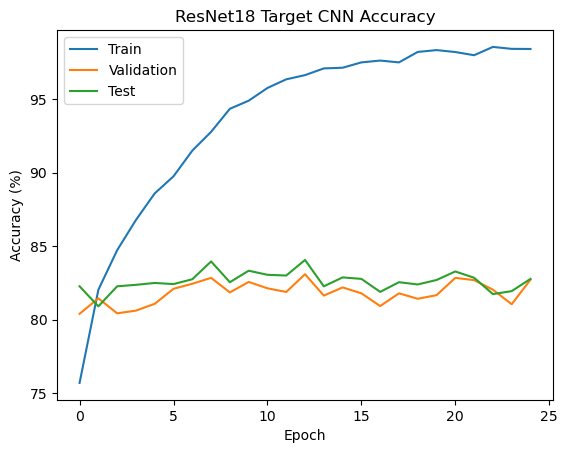

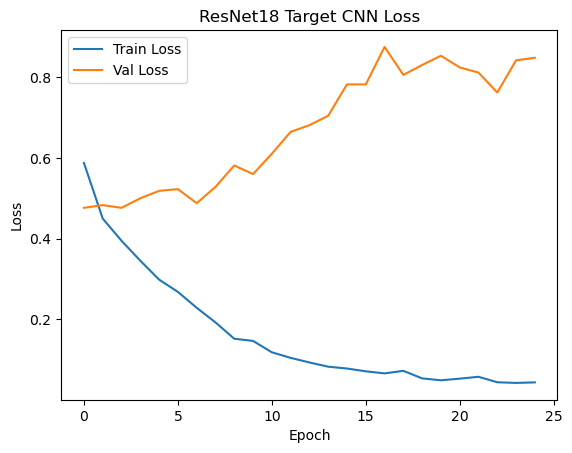

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# PATHS
TRAIN_DIR = "/home/student/Downloads/copycat_fer_project/train"
TEST_DIR  = "/home/student/Downloads/copycat_fer_project/test"
SAVE_PATH = "/home/student/Downloads/copycat_fer_project/target_resnet18_3class.pth"

# CONFIG
BATCH_SIZE = 32
EPOCHS = 25
LR = 3e-4
NUM_CLASSES = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Using device:", DEVICE)

# TRANSFORMS 
train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# DATASETS 
full_train = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
test_ds = datasets.ImageFolder(TEST_DIR, transform=test_tf)

print("Classes:", full_train.classes)

# 80/20 split
val_size = int(0.2 * len(full_train))
train_size = len(full_train) - val_size
train_ds, val_ds = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# MODEL 
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# METRICS 
train_acc, val_acc, test_acc = [], [], []
train_loss, val_loss = [], []

# TRAIN LOOP 
for epoch in range(EPOCHS):
    # TRAIN 
    model.train()
    correct, total, running_loss = 0,0,0

    for x,y in train_loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = out.argmax(1)
        correct += (pred==y).sum().item()
        total += y.size(0)

    ta = 100*correct/total
    tl = running_loss/len(train_loader)

    # VALIDATION
    model.eval()
    vc, vt, vl = 0,0,0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out,y)
            vl += loss.item()
            pred = out.argmax(1)
            vc += (pred==y).sum().item()
            vt += y.size(0)

    va = 100*vc/vt
    vl = vl/len(val_loader)

    # TEST EACH EPOCH 
    tc, tt = 0,0
    with torch.no_grad():
        for x,y in test_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            pred = out.argmax(1)
            tc += (pred==y).sum().item()
            tt += y.size(0)

    te = 100*tc/tt

    train_acc.append(ta)
    val_acc.append(va)
    test_acc.append(te)
    train_loss.append(tl)
    val_loss.append(vl)

    print(f"Epoch {epoch+1}: Train={ta:.2f}% Val={va:.2f}% Test={te:.2f}%")

# SAVE MODEL 
torch.save(model.state_dict(), SAVE_PATH)
print("Target model saved:", SAVE_PATH)

# ACCURACY GRAPH 
plt.figure()
plt.plot(train_acc,label="Train")
plt.plot(val_acc,label="Validation")
plt.plot(test_acc,label="Test")
plt.legend()
plt.title("ResNet18 Target CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.show()

# LOSS GRAPH 
plt.figure()
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label="Val Loss")
plt.legend()
plt.title("ResNet18 Target CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
 